# Predictive Maintance in Printing Industry

In [ ]:
!pip install pyjanitor

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import janitor
import keras
import time

# Reading and Exploring Data

In [6]:
df = pd.read_csv('sensor.csv')
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


# Preprocessing Data

In [7]:
#parse datetime stamp
format_str = '%Y-%m-%d %H:%M:%S'  # The format

df['timestamp'] = pd.DataFrame([datetime.datetime.strptime(date, format_str) for date in df['timestamp']])

In [8]:
df.shape
df.columns
100*df.isna().sum()/len(df)

Unnamed: 0          0.000000
timestamp           0.000000
sensor_00           4.633261
sensor_01           0.167484
sensor_02           0.008624
sensor_03           0.008624
sensor_04           0.008624
sensor_05           0.008624
sensor_06           2.177741
sensor_07           2.474129
sensor_08           2.317992
sensor_09           2.085603
sensor_10           0.008624
sensor_11           0.008624
sensor_12           0.008624
sensor_13           0.008624
sensor_14           0.009532
sensor_15         100.000000
sensor_16           0.014070
sensor_17           0.020879
sensor_18           0.020879
sensor_19           0.007262
sensor_20           0.007262
sensor_21           0.007262
sensor_22           0.018609
sensor_23           0.007262
sensor_24           0.007262
sensor_25           0.016340
sensor_26           0.009078
sensor_27           0.007262
sensor_28           0.007262
sensor_29           0.032680
sensor_30           0.118464
sensor_31           0.007262
sensor_32     

In [9]:
df = df.drop(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04','sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_15', 'sensor_30', 'sensor_31', 'sensor_32','sensor_33','sensor_34','sensor_35','sensor_36','sensor_37','sensor_38','sensor_39', 'sensor_40', 'sensor_41', 'sensor_42', 'sensor_43', 'sensor_44', 'sensor_45', 'sensor_46', 'sensor_47','sensor_48', 'sensor_49', 'sensor_50', 'sensor_51','Unnamed: 0'],axis=1)

df.head()

,timestamp,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,machine_status
0,2018-04-01 00:00:00,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,NORMAL
1,2018-04-01 00:01:00,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,NORMAL
2,2018-04-01 00:02:00,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,NORMAL
3,2018-04-01 00:03:00,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,NORMAL
4,2018-04-01 00:04:00,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,NORMAL


In [10]:
columns = [col for col in df.columns if not col.find('sensor')]
for col in columns:
    df[col] = df[col].fillna(df[col].mean())
df.shape
df.columns
100*df.isna().sum()/len(df)

timestamp         0.0
sensor_14         0.0
sensor_16         0.0
sensor_17         0.0
sensor_18         0.0
sensor_19         0.0
sensor_20         0.0
sensor_21         0.0
sensor_22         0.0
sensor_23         0.0
sensor_24         0.0
sensor_25         0.0
sensor_26         0.0
sensor_27         0.0
sensor_28         0.0
sensor_29         0.0
machine_status    0.0
dtype: float64

# Calculation Correlation and Heatmap

In [11]:
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score,fbeta_score

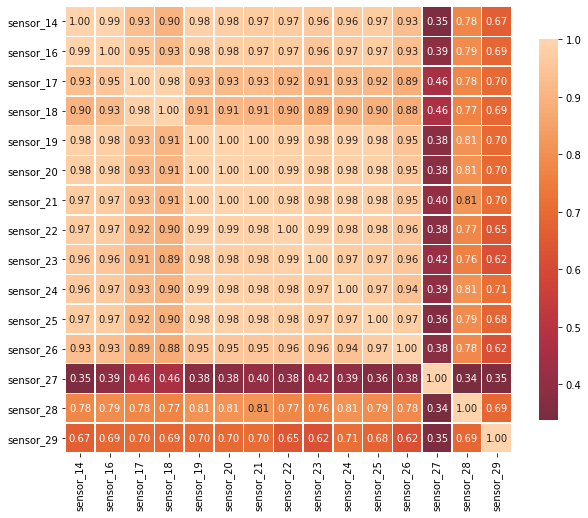

In [12]:
def correlation_heatmap(df):
    correlations = df.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.show();
    
correlation_heatmap(df)

# Finding RUL

In [13]:
def cal_rul(df):
    error = df[df['machine_status'] == 'BROKEN']
    arr=[]
    d = df['timestamp'].iloc[0]
    for date_error in error['timestamp']:
        
        filter = df.filter_date('timestamp',d, date_error)
        filter['rul'] = date_error - filter['timestamp']
        
        arr.append(filter)
        d = date_error
    
    result = pd.concat(arr)
    

    return result.loc[~result.index.duplicated(keep='first')] #remove duplicates indices

rul = cal_rul(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
rul['rul']

mod_time = np.timedelta64(14, 'D')#moderate_timeline
emer_time = np.timedelta64(7, 'D')#emergency_timeline
#label to show rul 14 days before failure

In [15]:
# fail1 indicates a failure will occur within the next 30 cycles, where 1 indicates failure, 0 indicates good cond 
rul['fail1'] = np.where(rul['rul'] <= mod_time, 1, 0 )

In [16]:
#Scaling
col_normalize = rul.columns.difference(['id','timestamp','rul','fail1','fail','machine_status'])
scaler = MinMaxScaler()
rul[col_normalize] = scaler.fit_transform(rul[col_normalize])

In [17]:
rul["rul"] = rul["rul"].apply(lambda x: x.total_seconds()/3600) #converting to hours

In [18]:
rul[rul['machine_status'] =="BROKEN"]

rul['time_norm']= rul['timestamp'].values.tolist()
rul["time_norm"] = (rul["time_norm"]-rul["time_norm"].min())/(rul["time_norm"].max()-rul["time_norm"].min())

train = rul.iloc[:77790,:].drop(['machine_status',"timestamp"],axis=1)
train["time_norm"] = (train["time_norm"]-train["time_norm"].min())/(train["time_norm"].max()-train["time_norm"].min())


test = rul.iloc[77791:,:].drop(['machine_status',"timestamp"],axis=1)
test["time_norm"] = (test["time_norm"]-test["time_norm"].min())/(test["time_norm"].max()-test["time_norm"].min())

train['rul'] = train['rul'].values.tolist()

In [19]:
test['rul'].describe()

count    88650.000000
mean       313.676782
std        231.096187
min          0.000000
25%        123.116667
50%        260.275000
75%        468.112500
max        837.483333
Name: rul, dtype: float64

In [20]:
feature=[column for column in df.columns if not column.find('sensor')]
target='fail1'

feature

['sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29']

# Modelling

In [21]:
seq_len=100
seq_col=feature

In [22]:
def gen_seq(id_df, seq_len, seq_col):
    data_mat = id_df[seq_col].values
    num_ele = data_mat.shape[0]
    for start, stop in zip(range(0, num_ele-seq_len), range(seq_len, num_ele)):
        yield data_mat[start:stop, :]

In [23]:
def gen_label(id_df, seq_len, label):
    data_mat = id_df[label].values
    num_ele = data_mat.shape[0]
    return data_mat[seq_len:num_ele, :]

In [24]:
seq_gen = [list(gen_seq(train, seq_len, seq_col))]

seq_arr = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_arr.shape)

(77690, 100, 15)


In [25]:
label_gen = [gen_label(train, seq_len, ['fail1'])]

label_arr = np.concatenate(label_gen).astype(np.float32)
label_arr.shape

(77690, 1)

In [26]:
def fbeta(y_true, y_pred, threshold=0):
    beta = 10

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [28]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation

In [29]:
nb_features = seq_arr.shape[2]
nb_out = label_arr[1]

# LSTM model
model = Sequential()

# The first layer
model.add(LSTM(
         input_shape=(seq_len, nb_features),
         units=100,
         return_sequences=True))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# The second layer
model.add(LSTM(
          units=50,
          return_sequences=False))

# Plus a 20% dropout rate
model.add(Dropout(0.2))

# Dense sigmoid layer
model.add(Dense(units=nb_out, activation='sigmoid'))

# With adam optimizer and a binary crossentropy loss. We will opimize for model accuracy.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[fbeta])

# Verify the architecture 
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 100)          46400     
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
t0 = time.time()
# fitting network
model.fit(seq_arr,label_arr,epochs=10,batch_size=200,validation_split=0.10,verbose=1,
        callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')])

Epoch 1/10
350/350 [==============================] - 15s 18ms/step - loss: 0.6243 - fbeta: 0.9381 - val_loss: 0.3913 - val_fbeta: 1.0000
Epoch 2/10
350/350 [==============================] - 5s 16ms/step - loss: 0.6342 - fbeta: 0.9091 - val_loss: 0.3924 - val_fbeta: 1.0000
Epoch 3/10
350/350 [==============================] - 5s 15ms/step - loss: 0.6150 - fbeta: 0.9489 - val_loss: 0.4223 - val_fbeta: 1.0000
Epoch 4/10
350/350 [==============================] - 5s 15ms/step - loss: 0.6017 - fbeta: 0.9690 - val_loss: 0.3281 - val_fbeta: 1.0000
Epoch 5/10
350/350 [==============================] - 5s 16ms/step - loss: 0.5853 - fbeta: 0.9399 - val_loss: 0.4607 - val_fbeta: 1.0000
Epoch 6/10
350/350 [==============================] - 5s 16ms/step - loss: 0.5708 - fbeta: 0.9728 - val_loss: 0.3929 - val_fbeta: 1.0000
Epoch 7/10
350/350 [==============================] - 5s 16ms/step - loss: 0.5450 - fbeta: 0.9496 - val_loss: 0.4095 - val_fbeta: 1.0000
Epoch 8/10
350/350 [====================

# Accuracy of the model

In [31]:
# training metrics
score = model.evaluate(seq_arr, label_arr, verbose=1, batch_size=200)
print('Training Accurracy: {}'.format(score[1]))

389/389 [==============================] - 3s 8ms/step - loss: 0.4623 - fbeta: 0.7323
Training Accurracy: 0.7323291301727295


In [32]:
# make predictions and compute confusion matrix
y_pred = model.predict_classes(seq_arr,verbose=1, batch_size=200)
y_true = label_arr
print('Training Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true, y_pred)
cm

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


389/389 [==============================] - 3s 7ms/step
Training Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels


array([[ 5839, 18808],
       [  339, 52704]])

In [33]:
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = 2 * (precision * recall) / (precision + recall)
print( 'Training Precision: ', precision, '\n', 'Training Recall: ', recall, '\n', 'Training F1 Score:', f1)
print(fbeta_score(y_true, y_pred,beta=0.5))

Training Precision:  0.7369951896185256 
 Training Recall:  0.9936089587693003 
 Training F1 Score: 0.8462767452129581
0.7771365208749274
